In [9]:
# !pip install transformers
# !pip install tensorflow
# !pip install pytorch-nlp

In [10]:
# from transformers import BertTokenizer, TFBertForSequenceClassification
# from transformers import InputExample, InputFeatures

# model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [11]:
# model.summary()

In [57]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [43]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

model = AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)

classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

res = classifier("I hate this movie")

In [44]:
print(res)

[{'label': 'NEGATIVE', 'score': 0.9996687173843384}]


In [15]:
# class Config:
#     batch_size = 128
#     epochs = 10
#     embed_dim = 128
#     validation_split = 0.15
#     maxlen = 192
#     vocab_size = 10000
#     labels = np.array(["neg", "pos"])
#     num_classes = len(labels)
#     label_display_names = np.array(["Negative", "Positive"])
#     model_path = "model.tf"
# config = Config()

In [16]:
# load data
data = pd.read_csv('../00_source_data/imdb_master.csv', encoding="unicode_escape")
data.head(10)

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt
5,5,test,"A funny thing happened to me while watching ""M...",neg,10004_2.txt
6,6,test,This German horror film has to be one of the w...,neg,10005_2.txt
7,7,test,"Being a long-time fan of Japanese film, I expe...",neg,10006_2.txt
8,8,test,"""Tokyo Eyes"" tells of a 17 year old Japanese g...",neg,10007_4.txt
9,9,test,Wealthy horse ranchers in Buenos Aires have a ...,neg,10008_4.txt


<AxesSubplot: >

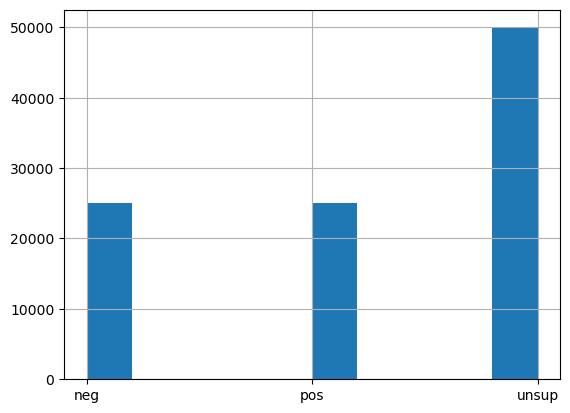

In [17]:
data["label"].hist()

In [18]:
data = data[(data["label"] == "neg") | (data["label"] == "pos")]

<AxesSubplot: >

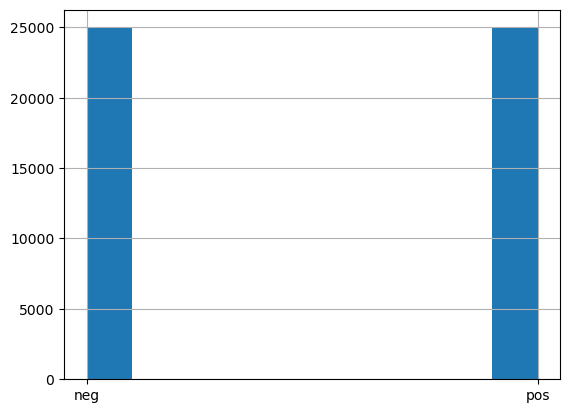

In [19]:
data["label"].hist()

## Build a TextVectorization layer

In [24]:
# data preprocessing
# 1. Remove the HTML tags
# 2. Remove any punctuations or a limited set of special characters like, or . or #, etc.
# 3. Check if the word is made up of English letters and is not alpha-numeric
# 4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
# 5. Convert the word to lowercase
# 6. Remove Stopwords (the, and, a ...)
# 7. Finally Snowball Stemming (remove -ing, -ly, ...)

stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    return cleaned

In [25]:
i=0
str1=' '
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''
for sent in data['review'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) 
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (data['label'].values)[i] == "pos": 
                        all_positive_words.append(s) 
                    if(data['label'].values)[i] == "neg":
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) 
    final_string.append(str1)
    i+=1

In [26]:
# add cleaned_review column
data['cleaned_review'] = final_string

In [27]:
# add score column
def posneg(x):
    if x == 'neg':
        return 0
    elif x == 'pos':
        return 1
    return x

filtered_score = data['label'].map(posneg)
data['score'] = filtered_score

In [28]:
sample_txt = 'I hate this movie so much.'

In [29]:
# encoding = tokenizer.encode_plus(
#   sample_txt,
#   max_length=32,
#   add_special_tokens=True, # Add '[CLS]' and '[SEP]'
#   return_token_type_ids=False,
#   pad_to_max_length=True,
#   return_attention_mask=True,
#   return_tensors='pt',  # Return PyTorch tensors
#   truncation = True
# )

# encoding.keys()

/Users/yer1k/opt/miniconda3/envs/tf/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [30]:
data.head()

,Unnamed: 0,type,review,label,file,cleaned_review,score
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt,b'costner drag movi far longer necessari asid ...,0
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt,b'exampl major action film generic bore there ...,0
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt,b'first hate moron rapper couldnt act gun pres...,0
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt,b'even beatl could write song everyon like alt...,0
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt,b'brass pictur movi fit word realli somewhat b...,0


In [46]:
# token_lens = []

# for txt in data.review:
#   tokens = tokenizer.encode(txt, max_length=512, truncation=True)
#   token_lens.append(len(tokens))

/var/folders/rp/l0l3mhgx4zs1vfg5y9_c2qw80000gn/T/ipykernel_37379/3638548306.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


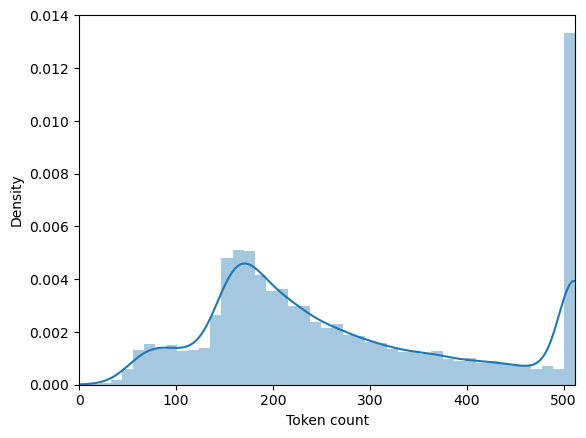

In [49]:
# sns.distplot(token_lens)
# plt.xlim([0, 512]);
# plt.xlabel('Token count');

In [50]:
# MAX_LEN = 400

In [53]:
# class MovieReviewDataset(Dataset):

#   def __init__(self, reviews, targets, tokenizer, max_len):
#     self.reviews = reviews
#     self.targets = targets
#     self.tokenizer = tokenizer
#     self.max_len = max_len
  
#   def __len__(self):
#     return len(self.reviews)
  
#   def __getitem__(self, item):
#     review = str(self.reviews[item])
#     target = self.targets[item]

#     encoding = self.tokenizer.encode_plus(
#       review,
#       add_special_tokens=True,
#       max_length=self.max_len,
#       return_token_type_ids=False,
#       pad_to_max_length=True,
#       return_attention_mask=True,
#       return_tensors='pt',
#       truncation = True
#     )

#     return {
#       'review_text': review,
#       'input_ids': encoding['input_ids'].flatten(),
#       'attention_mask': encoding['attention_mask'].flatten(),
#       'targets': torch.tensor(target, dtype=torch.long)
#     }

In [58]:
# df_train, df_test = train_test_split(data, test_size=0.3, random_state=RANDOM_SEED)
# df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [59]:
# df_train.shape, df_val.shape, df_test.shape

((35000, 7), (7500, 7), (7500, 7))

In [62]:
# def create_data_loader(df, tokenizer, max_len, batch_size):
#   ds = MovieReviewDataset(
#     reviews=df.review.to_numpy(),
#     targets=df.score.to_numpy(),
#     tokenizer=tokenizer,
#     max_len=max_len
#   )

#   return DataLoader(
#     ds,
#     batch_size=batch_size,
#     num_workers=4
#   )

In [63]:

# BATCH_SIZE = 16

# train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
# val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
# test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# data = next(iter(train_data_loader))
# data.keys()